In [42]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from tensorflow.keras import layers, Model, optimizers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate, Input, Conv3D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import os
from keras.regularizers import l2
from keras.constraints import MinMaxNorm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import backend as K
# Set default floating-point type to float64
tf.keras.backend.set_floatx('float64')

In [62]:
sorted_concatenated_csv = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/test_data_concat/sorted_concatenated_data.csv"
data = pd.read_csv(sorted_concatenated_csv)
data.drop(columns=['zCOM'], inplace=True)
print(data.head())
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
smallest_values = data[cytokine_columns].min()
largest_values = data[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values)
print("\nLargest values for each cytokine:")
print(largest_values)
def replace_negative_with_zero(data):
    num_negative_values = (data < 0).sum().sum()
    data[data < 0] = 0

    return num_negative_values

cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

for col in cytokine_columns:
    num_negatives = replace_negative_with_zero(data[col])
    print(f"Number of negative values replaced with 0 in '{col}': {num_negatives}")

# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# get unique time values
unique_time = data['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    data_time = data[data['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array = np.zeros((50, 50, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations = data_time[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    # store array for current value of time
    arrays[time] = array

   mcsteps  xCOM  yCOM           il8  il1  il6  il10  tnf  tgf
0        0    33    22  3.750408e-07  0.0  0.0   0.0  0.0  0.0
1        0    11    32  4.793328e-09  0.0  0.0   0.0  0.0  0.0
2        0    30    35  8.997935e-09  0.0  0.0   0.0  0.0  0.0
3        0    17    40  1.781103e-08  0.0  0.0   0.0  0.0  0.0
4        0    21    23  4.789621e-09  0.0  0.0   0.0  0.0  0.0
       time  xCOM  yCOM           il8           il1           il6  \
0         0    33    22  3.750408e-07  0.000000e+00  0.000000e+00   
1         0    11    32  4.793328e-09  0.000000e+00  0.000000e+00   
2         0    30    35  8.997935e-09  0.000000e+00  0.000000e+00   
3         0    17    40  1.781103e-08  0.000000e+00  0.000000e+00   
4         0    21    23  4.789621e-09  0.000000e+00  0.000000e+00   
...     ...   ...   ...           ...           ...           ...   
86155   100    49    35 -8.886183e-11  6.343394e-10  1.206925e-08   
86156   100    36     4  1.334245e-07  1.665160e-07  1.305691e-08   
8

C:\Users\Ioannis\AppData\Local\Temp\ipykernel_18096\2417481198.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_18096\2417481198.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_18096\2417481198.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Tem

In [63]:
print("Number of arrays:", len(arrays))
array = arrays[1]
print("Shape of the array:", array.shape)
print("Value at position (0,45):", array[0,45])

Number of arrays: 101
Shape of the array: (50, 50, 6)
Value at position (0,45): [0.00000e+00 6.79662e-23 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]


In [64]:
sequence_length = 10
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

print(input_sequences.shape)
print(output_values.shape)

(91, 10, 50, 50, 6)
(91, 50, 50, 6)


In [65]:
# Metrics and lr schedule callback
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-4
    if epoch < 400:
        return 1e-5
    else:
        return 1e-6

def r_squared(y_true, y_pred):
    SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def average_relative_rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square((y_pred - y_true) / tf.keras.backend.clip(tf.keras.backend.abs(y_true), tf.keras.backend.epsilon(), None))))

def accuracy(y_true, y_pred):
    abs_diff = K.abs(y_true - y_pred)
    threshold = 0.2 * y_true
    accurate_predictions = K.less_equal(abs_diff, threshold)
    accuracy = K.mean(accurate_predictions)
    return accuracy

In [79]:
input_shape = (10, 50, 50, 6)
def model(input_shape):
    input_layer = layers.Input(shape=input_shape)
   
    x= layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    x= Reshape((sequence_length, -1))(x)
    x= layers.LSTM(units=64, return_sequences=True)(x)
    x= layers.LSTM(units=64)(x)
    x= layers.Dense(units=50*50*6, activation='elu')(x)
    output_layer = layers.Reshape((50, 50, 6))(x)

    return Model(inputs=input_layer, outputs=output_layer)

model = model(input_shape)

In [68]:
input_shape = (10, 50, 50, 6)
# model architecture
def model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(64)(x)
    
    x = layers.Dense(50 * 50 * 6)(x) 
    output_layer = layers.Reshape((50, 50, 6))(x)
    
    return Model(inputs=input_layer, outputs=output_layer)

model = model(input_shape)

In [80]:
# Define the parameters for the PDE solver
Dil8 = 2.09e-6  # Diffusion coefficient for IL-8
Dil1 = 3e-7     # Diffusion coefficient for IL-1
Dil6 = 8.49e-8  # Diffusion coefficient for IL-6
Dil10 = 1.45e-8  # Diffusion coefficient for IL-10
Dtnf = 4.07e-9  # Diffusion coefficient for TNF
Dtgf = 2.6e-7   # Diffusion coefficient for TGF

muil8 = 0.2     # Degradation rate for IL-8
muil1 = 0.6     # Degradation rate for IL-1
muil6 = 0.5     # Degradation rate for IL-6
muil10 = 0.5    # Degradation rate for IL-10
mutnf = 0.1125  # Degradation rate for TNF
mutgf = 0.02    # Degradation rate for TGF

keil8 = 234e-5       # Production rate for IL-8
kndnil8 = 1.46e-5    # Additional source term for IL-8
thetanail8 = 3.024e-5  # Negative feedback/inhibition term for IL-8
knail1 = 225e-5      # Production rate for IL-1
km1il6 = 250e-5      # Production rate for IL-6
km2il10 = 45e-5      # Production rate for IL-10
knatnf = 250e-5      # Production rate for TNF
km1tnf = 70e-5       # Additional source term for TNF
km2tgf = 280e-5      # Production rate for TGF

# Define the custom loss layer
class CustomLossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        y_pred, y_true = inputs
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # Compute the physical constraints
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(y_pred)
            il8, il1, il6, il10, tnf, tgf = tf.split(y_pred, num_or_size_splits=6, axis=-1)
            
            # Compute spatial gradients for each cytokine
            grad_il8 = tape.gradient(il8, y_pred)
            grad_il1 = tape.gradient(il1, y_pred)
            grad_il6 = tape.gradient(il6, y_pred)
            grad_il10 = tape.gradient(il10, y_pred)
            grad_tnf = tape.gradient(tnf, y_pred)
            grad_tgf = tape.gradient(tgf, y_pred)
            
            # Compute the reaction-diffusion equations for each cytokine
            rd_il8 = Dil8 * grad_il8 - muil8 * il8 + keil8 * il8 + kndnil8 * il8 - thetanail8 * il8
            rd_il1 = Dil1 * grad_il1 - muil1 * il1 + knail1 * il1
            rd_il6 = Dil6 * grad_il6 - muil6 * il6 + km1il6 * il6
            rd_il10 = Dil10 * grad_il10 - muil10 * il10 + km2il10 * il10
            rd_tnf = Dtnf * grad_tnf - mutnf * tnf + knatnf * tnf + km1tnf * tnf
            rd_tgf = Dtgf * grad_tgf - mutgf * tgf + km2tgf * tgf

         # Compute the physics loss for each cytokine
        physics_loss_il8 = tf.reduce_mean(tf.square(rd_il8))
        physics_loss_il1 = tf.reduce_mean(tf.square(rd_il1))
        physics_loss_il6 = tf.reduce_mean(tf.square(rd_il6))
        physics_loss_il10 = tf.reduce_mean(tf.square(rd_il10))
        physics_loss_tnf = tf.reduce_mean(tf.square(rd_tnf))
        physics_loss_tgf = tf.reduce_mean(tf.square(rd_tgf))
        
        # Aggregate the physics losses
        total_physics_loss = (physics_loss_il8 + 
                              physics_loss_il1 + 
                              physics_loss_il6 + 
                              physics_loss_il10 + 
                              physics_loss_tnf + 
                              physics_loss_tgf)
        
        total_loss = mse_loss + total_physics_loss
        self.add_loss(total_loss)
        return y_pred

In [81]:
# Apply the custom loss layer
y_true = layers.Input(shape=(50, 50, 6))
custom_loss_layer = CustomLossLayer()([model.output, y_true])
final_model = Model(inputs=[model.input, y_true], outputs=custom_loss_layer)

# data split
train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)
initial_lr = 1e-4

# compile, fit
final_model.compile(optimizer=Adam(learning_rate=initial_lr),  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])

history = final_model.fit([X_train, y_train], y_train, validation_data=([X_val, y_val], y_val), epochs=500, batch_size=40, callbacks=[lr_scheduler, early_stopping])

Epoch 1/500
2/2 [==============================] - 4s 945ms/step - loss: 5.0020e-12 - r_squared: 0.0174 - mape: 37.8397 - accuracy: 0.0015 - average_relative_rmse: 0.5039 - msle: 4.2122e-12 - mae: 4.4370e-07 - val_loss: 1.0116e-11 - val_r_squared: 0.0434 - val_mape: 57.5220 - val_accuracy: 0.0028 - val_average_relative_rmse: 0.7079 - val_msle: 9.3109e-12 - val_mae: 7.0477e-07 - lr: 1.0000e-04
Epoch 2/500
2/2 [==============================] - 1s 378ms/step - loss: 4.9154e-12 - r_squared: 0.0381 - mape: 35.1211 - accuracy: 0.0018 - average_relative_rmse: 0.4736 - msle: 4.1794e-12 - mae: 4.3649e-07 - val_loss: 9.9231e-12 - val_r_squared: 0.0625 - val_mape: 54.5598 - val_accuracy: 0.0028 - val_average_relative_rmse: 0.6740 - val_msle: 9.1541e-12 - val_mae: 6.9574e-07 - lr: 1.0000e-04
Epoch 3/500
2/2 [==============================] - 1s 373ms/step - loss: 4.8326e-12 - r_squared: 0.0658 - mape: 32.8466 - accuracy: 0.0019 - average_relative_rmse: 0.4505 - msle: 4.0633e-12 - mae: 4.2775e-07 

In [76]:
y_pred = model.predict(X_test)

loss = final_model.evaluate([X_test, y_test], y_test)
print(f'Test Loss: {loss}')

1/1 [==============================] - 0s 99ms/step - loss: 6.3997e-12 - r_squared: 0.5273 - mape: 77.5176 - accuracy: 0.4191 - average_relative_rmse: 3.6869 - msle: 5.3399e-12 - mae: 5.7758e-07
Test Loss: [6.399682390372219e-12, 0.5273465237163795, 77.5176159219315, 0.41905263157894734, 3.686895512757977, 5.339938738463474e-12, 5.775797569941947e-07]


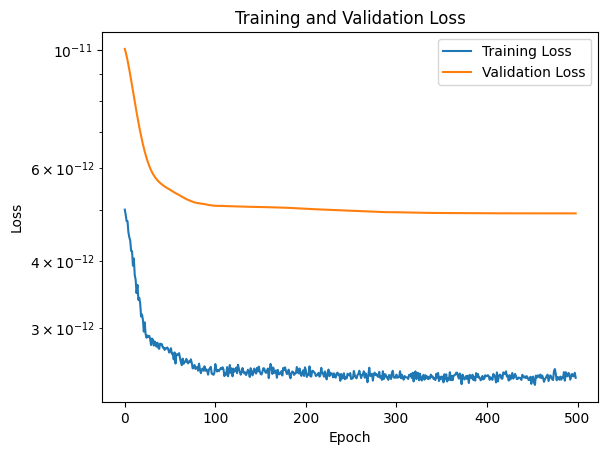

In [77]:
train_loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# save the plot to the specified folder
plot_filename = f'loss.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

1/1 [==============================] - 0s 21ms/step
(19, 50, 50, 6)
(19, 50, 50, 6)
(47500, 6)
(47500, 6)


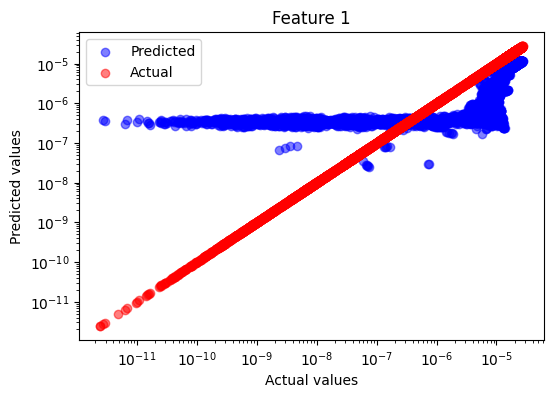

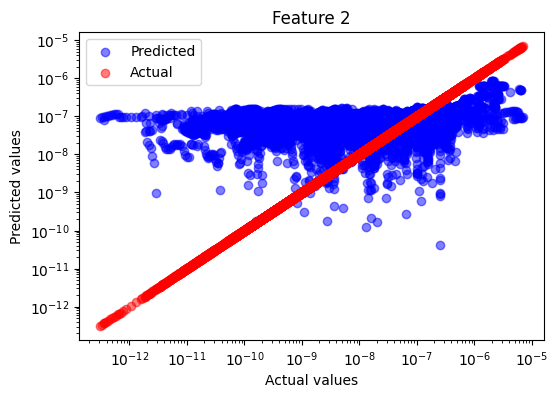

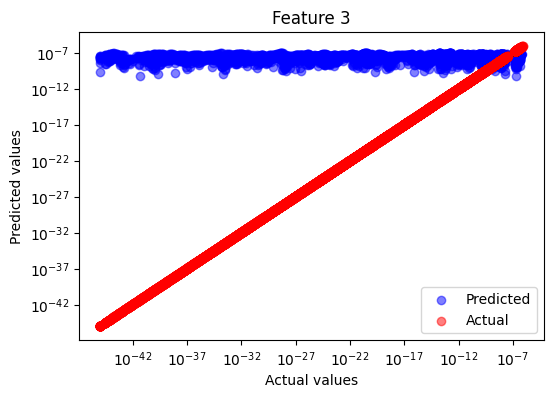

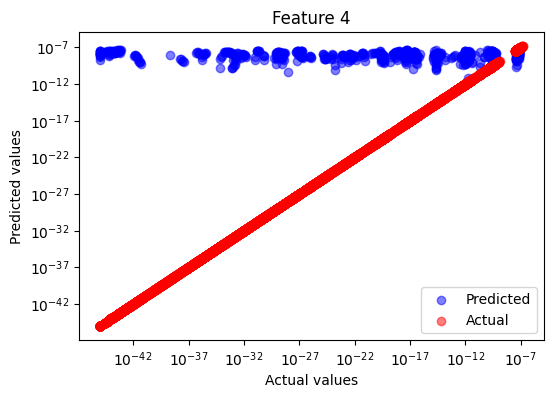

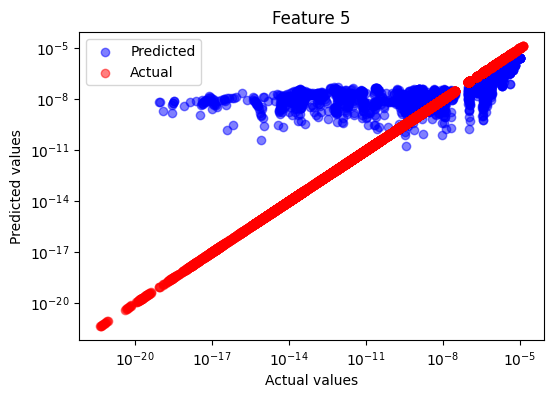

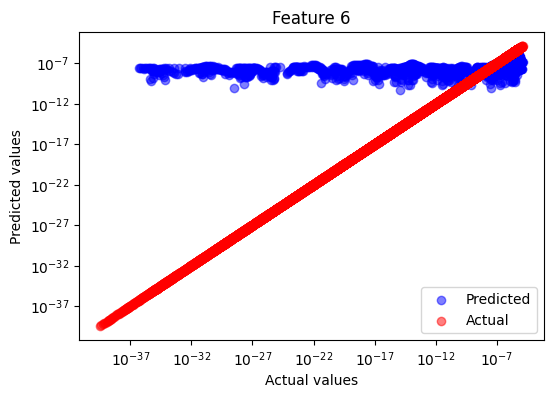

In [78]:
y_pred=model.predict(X_test)
print(y_test.shape)
print(y_pred.shape)
y_pred_shape = y_pred.shape
y_test_shape=y_test.shape

# reshape the tensor to (91*50*50, 6)
y_pred_flattened = np.reshape(y_pred, (-1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (-1, y_test_shape[-1]))

df = pd.DataFrame(y_pred_flattened, columns=[f'feature_{i+1}' for i in range(y_pred_shape[-1])])

df.to_csv('data/flattened_y_pred.csv', index=False)

print(y_test_flattened.shape)
print(y_pred_flattened.shape)

output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

num_features = y_test_flattened.shape[1]
for i in range(num_features):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_flattened[:, i], y_pred_flattened[:, i], color='blue', alpha=0.5, label='Predicted')
    plt.scatter(y_test_flattened[:, i], y_test_flattened[:, i], color='red', alpha=0.5, label='Actual')
    plt.title(f'Feature {i+1}')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # save the plot to the specified folder
    plot_filename = f'feature_{i+1}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    
    plt.show()